Train/Val/Test split

LSTM Autoencoder

Randomized sentetik anomaly injection

Sliding windows

Reconstruction error hesaplama

Pointwise error atama

Thresholding + ROC/F1/AP skorları

Görselleştirme

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, average_precision_score
import matplotlib.pyplot as plt

In [ ]:

# ------------------ 0️⃣ Device ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

In [ ]:
# ------------------ 1️⃣ Load Data ------------------
train_df = pd.read_csv("../data/processed/etth1_train.csv", parse_dates=["date"], index_col="date")
val_df   = pd.read_csv("../data/processed/etth1_val.csv", parse_dates=["date"], index_col="date")
test_df = pd.read_csv("../data/processed/etth1_test.csv")

In [ ]:
# ------------------ 2️⃣ Normalize ------------------
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df["OT"].values.reshape(-1, 1)).flatten()
print(f"Train series length: {len(train_scaled)}")
val_scaled   = scaler.transform(val_df["OT"].values.reshape(-1, 1)).flatten()

test_scaled = scaler.transform(test_df["OT"].values.reshape(-1, 1)).flatten()
print(f"Test series length: {len(test_scaled)}")


In [ ]:

# ------------------ 3️⃣ Sliding window ------------------
def create_windows(data, window_size):
    return np.array([data[i:i+window_size] for i in range(len(data) - window_size + 1)])


window_size = 96
train_windows = create_windows(train_scaled, window_size)
val_windows   = create_windows(val_scaled, window_size)
test_windows  = create_windows(test_scaled, window_size)

train_tensor = torch.tensor(train_windows, dtype=torch.float32).unsqueeze(-1)
val_tensor   = torch.tensor(val_windows, dtype=torch.float32).unsqueeze(-1)
test_tensor  = torch.tensor(test_windows, dtype=torch.float32).unsqueeze(-1)

batch_size = 64
train_loader_ae = DataLoader(TensorDataset(train_tensor, train_tensor), batch_size=batch_size, shuffle=True)
val_loader_ae   = DataLoader(TensorDataset(val_tensor, val_tensor), batch_size=batch_size, shuffle=False)
test_loader_ae  = DataLoader(TensorDataset(test_tensor, test_tensor), batch_size=batch_size, shuffle=False)


In [ ]:
# ------------------ 4️⃣ LSTM Autoencoder ------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=2, dropout=0.2):
        super().__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.enc_fc  = nn.Linear(hidden_dim, latent_dim)
        self.dec_fc  = nn.Linear(latent_dim, hidden_dim)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.output  = nn.Linear(hidden_dim, input_dim)
        self.dropout = nn.Dropout(dropout)
        self.layernorm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        _, (h_n, _) = self.encoder(x)
        last_h = h_n[-1]
        latent = self.enc_fc(last_h)
        T = x.size(1)
        dec_input = self.dec_fc(latent).unsqueeze(1).repeat(1, T, 1)
        dec_input = self.layernorm(dec_input)
        dec_input = self.dropout(dec_input)
        dec_out, _ = self.decoder(dec_input)
        out = self.output(dec_out)
        return out

input_dim  = 1
hidden_dim = 64
latent_dim = 16
num_layers = 2

model = LSTMAutoencoder(input_dim, hidden_dim, latent_dim, num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
loss_fn = nn.MSELoss()
# loss_fn= nn.SmoothL1Loss(beta=0.5) # make the loss more anomaly-sensitive(to boost recall)

In [8]:
# ------------------ 5️⃣ Training Loop ------------------
num_epochs = 100
patience   = 12
best_val   = np.inf
pat_cnt    = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for xb, _ in train_loader_ae:
        xb = xb.to(device)
        noisy = xb + 0.02 * torch.randn_like(xb).to(device)
        optimizer.zero_grad()
        out = model(noisy)
        loss = loss_fn(out, xb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader_ae.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, _ in val_loader_ae:
            xb = xb.to(device)
            out = model(xb)
            val_loss += loss_fn(out, xb).item() * xb.size(0)
    val_loss /= len(val_loader_ae.dataset)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train: {train_loss:.6f} - Val: {val_loss:.6f}")

    if val_loss < best_val:
        best_val = val_loss
        pat_cnt = 0
        best_state = model.state_dict()
    else:
        pat_cnt += 1
        if pat_cnt >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

model.load_state_dict(best_state)


Epoch 65/100 - Train: 0.030855 - Val: 0.016436
Early stopping at epoch 65


<All keys matched successfully>

In [2]:
# evalueate on test set
model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in test_loader_ae:
        xb = xb.to(device)
        preds = model(xb).cpu().numpy()
        all_preds.append(preds)

all_preds = np.concatenate(all_preds, axis=0).squeeze(-1)
test_windows_np = test_windows

# Reconstruction error per window (MSE)
reconstruction_errors = np.mean((all_preds - test_windows_np) ** 2, axis=1)

plt.figure(figsize=(12, 5))
plt.plot(reconstruction_errors, label="Reconstruction Error")
plt.title("Reconstruction Error on Test Set")
plt.xlabel("Window Index")
plt.ylabel("Error")
plt.legend()
plt.show()

NameError: name 'model' is not defined

In [10]:
def inject_point_anomaly(window, severity=0.5):
    """Injects a single spike into the window."""
    w = window.copy()
    idx = np.random.randint(len(w))
    w[idx] += severity * np.max(w)  # Add spike
    return w

def inject_contextual_anomaly(window, severity=0.3):
    """Injects an anomaly by shifting a segment's mean."""
    w = window.copy()
    start = np.random.randint(len(w) // 2)
    length = np.random.randint(1, len(w) // 2)
    w[start:start+length] += severity * np.std(w)  # Context shift
    return w

def inject_collective_anomaly(window, severity=0.3):
    """Injects an anomaly by replacing a block with higher variance values."""
    w = window.copy()
    start = np.random.randint(len(w) // 2)
    length = np.random.randint(2, len(w) // 2)
    w[start:start+length] = np.random.normal(
        loc=np.mean(w) + severity * np.std(w),
        scale=np.std(w) * (1 + severity),
        size=length
    )
    return w


Low-error windows indices: [ 186  187  188  189  190  191  192  193  194  195  196  197  198  199
  200  201  202  806  807  808  809  810  811  812  813  814  815  816
  817  818  937  938  939  940  941  942  943  944  945  946  947  949
  951  952  953  954  955  956  957  958  959  960  964  965  966  967
  968  969  970  971  972  973  974  975  976  977  978  979  980  981
  982  983  984  985  986  987  988  989  990  991  992  993  994  995
  996  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007 1008 1009
 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023
 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037
 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051
 1052 1053 1077 1078 1079 1080 1081 1082 1083 1084 1085 1086 1087 1088
 1577 1578 1579 1580 1581 1582 1583 1642 1644 1645 1646]
Example index for anomaly injection: 943


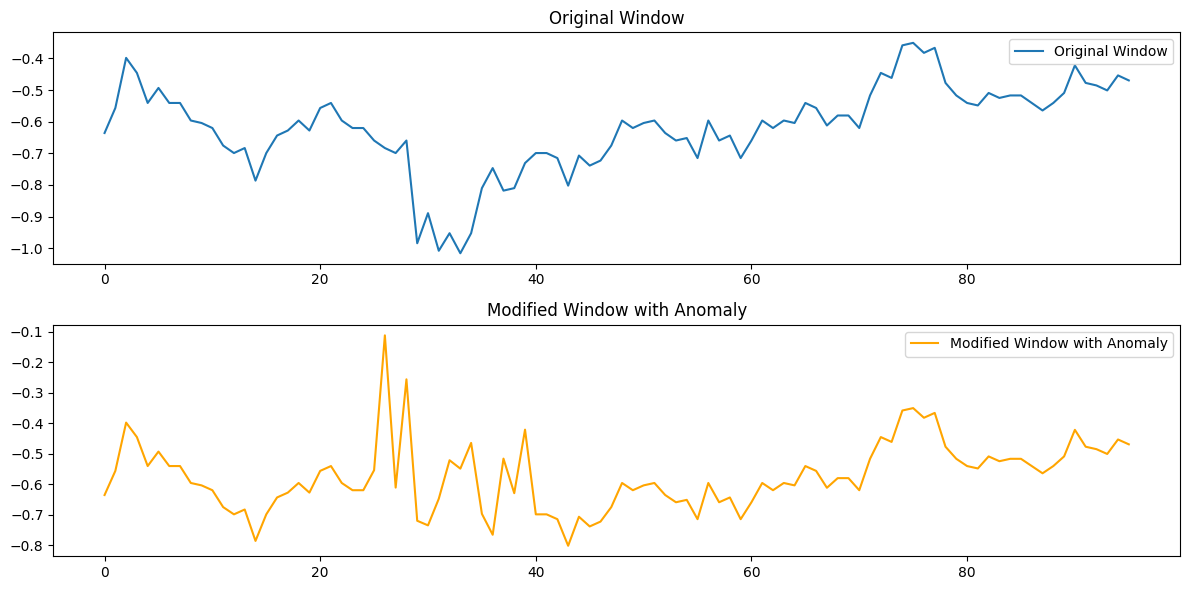

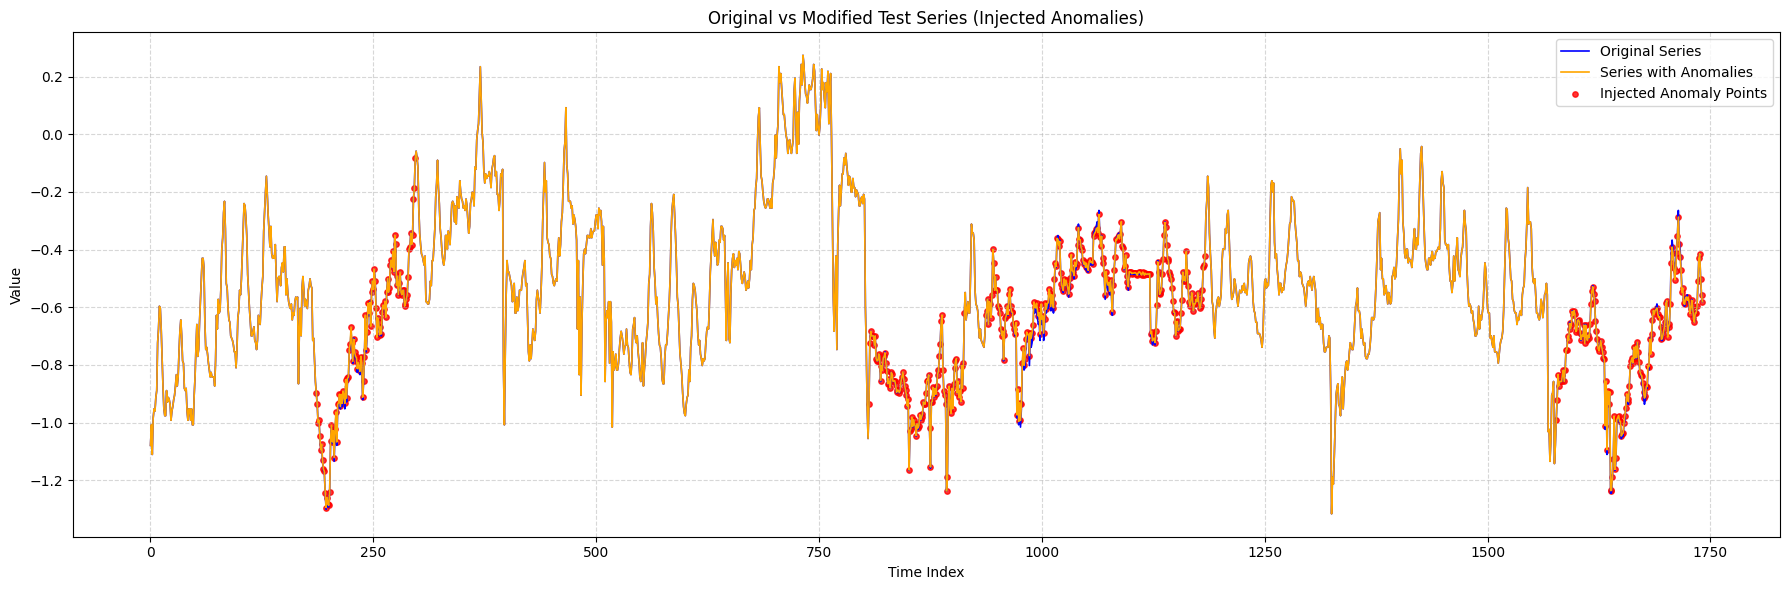

In [11]:
# Find low-error windows (non-anomalies)

low_error_indices = np.where(reconstruction_errors < np.percentile(reconstruction_errors, 10))[0] #lowest 10 windows
print(f"Low-error windows indices: {(low_error_indices)}")

# Inject anomalies into selected windows
modified_test_windows = test_windows.copy()
injected_labels = np.zeros(len(test_windows), dtype=int)  # 0 = normal, 1 = anomaly

for idx in low_error_indices:
            if np.random.rand() < 0.5:
                modified_test_windows[idx] = inject_contextual_anomaly(modified_test_windows[idx])
            else:
                modified_test_windows[idx] = inject_collective_anomaly(modified_test_windows[idx])
            injected_labels[idx] = 1  # Mark as anomaly

example_idx = np.random.choice(low_error_indices)
print(f"Example index for anomaly injection: {example_idx}")

# ı want to show before and after anomaly enjection to test data on one plot, plot should be consist of two part, left part is original(non-anomalies), right part consist of anomalies. I want to see what kind of change in the signal is caused by adding anomalies to the test data set.

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(test_windows[example_idx], label="Original Window")
plt.title("Original Window")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(modified_test_windows[example_idx], label="Modified Window with Anomaly", color='orange')
plt.title("Modified Window with Anomaly")
plt.legend()
plt.tight_layout()
plt.show()



# (Optional) visualize one example before/after
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.plot(test_windows[example_idx], label="Original Window")
# plt.title("Original Window")    
# plt.legend()
# plt.subplot(2, 1, 2)
# plt.plot(modified_test_windows[example_idx], label="Modified Window with Anomaly", color='orange')
# plt.title("Modified Window with Anomaly")
# plt.legend()
# plt.tight_layout()
# plt.show()


# Reconstruct full series from modified windows
reconstructed_series = np.zeros(len(test_scaled))
counts = np.zeros(len(test_scaled))
for i, w in enumerate(modified_test_windows):
    for j in range(window_size):
        reconstructed_series[i+j] += w[j]
        counts[i+j] += 1
reconstructed_series[counts>0] /= counts[counts>0]

# Mark anomaly points for plotting
pointwise_anomalies = np.zeros(len(test_scaled))
for i, label in enumerate(injected_labels):
    if label == 1:
        pointwise_anomalies[i:i+window_size] = 1

# Plot original vs modified series
plt.figure(figsize=(18, 6))
plt.plot(test_scaled, label="Original Series", color="blue", linewidth=1.2)
plt.plot(reconstructed_series, label="Series with Anomalies", color="orange", linewidth=1.2)

# Highlight anomaly points on the modified series
plt.scatter(
    np.where(pointwise_anomalies == 1)[0],
    reconstructed_series[pointwise_anomalies == 1],
    color='red', s=15, label='Injected Anomaly Points', alpha=0.8
)

plt.title("Original vs Modified Test Series (Injected Anomalies)")
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Best threshold: 0.007402 with F1-score: 0.5324
ROC AUC: 0.1433
Precision: 0.3628, Recall: 1.0000, F1: 0.5324, AP: 0.2233


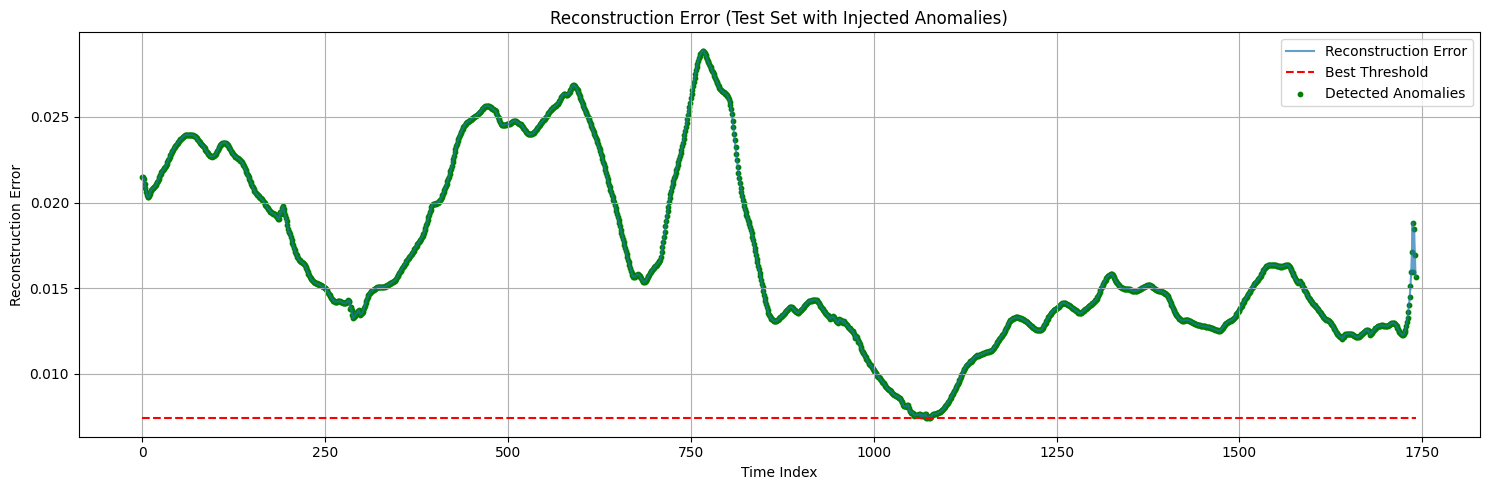

In [12]:
# =========  Prepare new DataLoader with anomalies =========
test_tensor_anom = torch.tensor(modified_test_windows, dtype=torch.float32).unsqueeze(-1)
test_loader_anom = DataLoader(TensorDataset(test_tensor_anom, test_tensor_anom),
                              batch_size=batch_size, shuffle=False)

# =========  Reconstruction & Error Calculation =========
model.eval()
recons = []
with torch.no_grad():
    for xb, _ in test_loader_anom:
        xb = xb.to(device)
        out = model(xb).cpu().numpy()
        recons.append(out)

recons = np.vstack(recons).squeeze(-1)
window_mse = np.mean((recons - modified_test_windows) ** 2, axis=1)

# Convert window error to pointwise error
N = len(test_scaled)
pointwise_err = np.zeros(N)
counts = np.zeros(N)
half = window_size // 2

for i, w_err in enumerate(window_mse):
    start_idx = i
    end_idx = i + window_size
    if end_idx > N:
        end_idx = N
    pointwise_err[start_idx:end_idx] += w_err
    counts[start_idx:end_idx] += 1

# Average overlapping contributions
nonzero = counts > 0
pointwise_err[nonzero] /= counts[nonzero]

valid_err = pointwise_err
valid_labels = np.zeros(N, dtype=int)

# Map window-level anomaly labels to pointwise
for idx in np.where(injected_labels == 1)[0]:
    start_idx = idx
    end_idx = idx + window_size
    if end_idx > N:
        end_idx = N
    valid_labels[start_idx:end_idx] = 1

# ========= Threshold Optimization & Metrics =========
thresholds = np.linspace(valid_err.min(), valid_err.max(), 200)
f1_scores = []

for thr in thresholds:
    preds = (valid_err >= thr).astype(int)
    f1_scores.append(f1_score(valid_labels, preds))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold: {best_threshold:.6f} with F1-score: {best_f1:.4f}")

preds = (valid_err >= best_threshold).astype(int)

roc_auc = roc_auc_score(valid_labels, valid_err)
precision = precision_score(valid_labels, preds)
recall = recall_score(valid_labels, preds)
f1 = f1_score(valid_labels, preds)
ap_score = average_precision_score(valid_labels, valid_err)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AP: {ap_score:.4f}")

# ========= Optional Visualization =========
plt.figure(figsize=(15,5))
plt.plot(pointwise_err, label='Reconstruction Error', alpha=0.7)
plt.hlines(best_threshold, 0, N, colors='r', linestyles='dashed', label='Best Threshold')
plt.scatter(np.where(preds==1)[0], pointwise_err[preds==1], color='green', label='Detected Anomalies', s=10)
plt.title('Reconstruction Error (Test Set with Injected Anomalies)')
plt.xlabel('Time Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Test series length: 13936
Test series with anomalies length: 13936


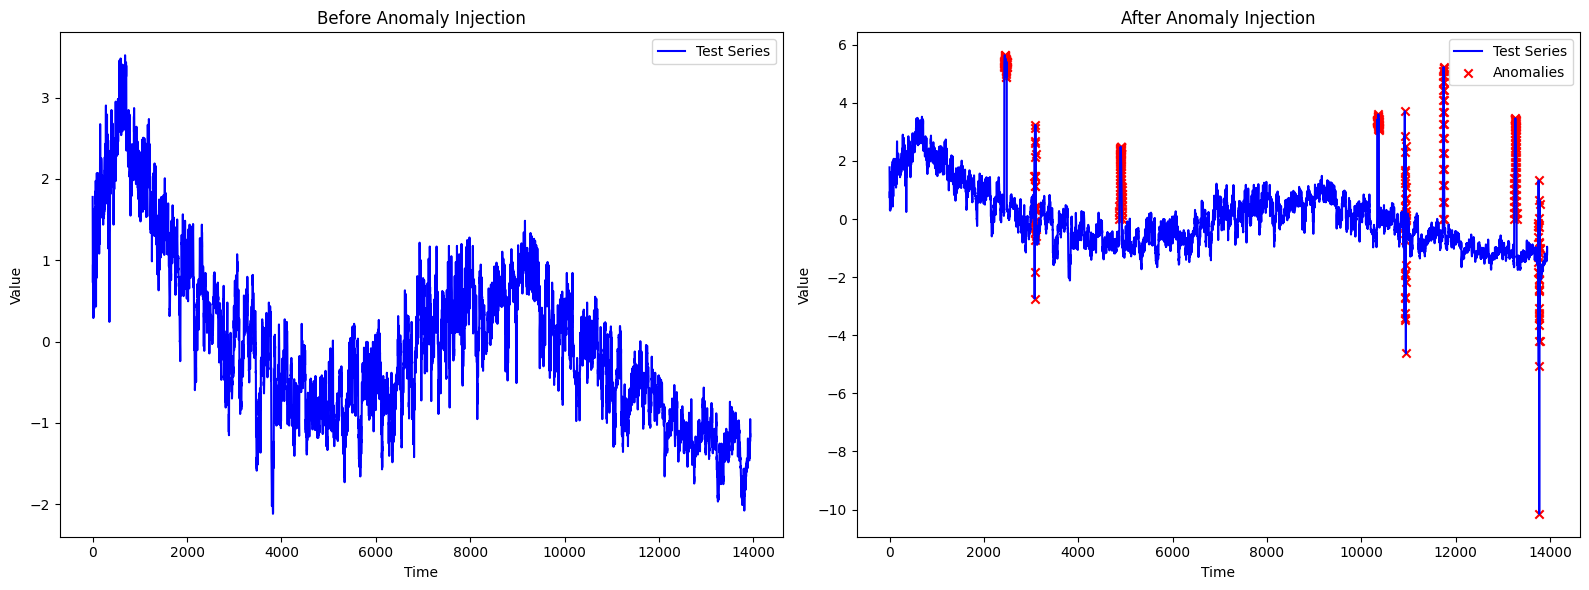

In [13]:
# ------------------ 6️⃣ Random Synthetic Anomalies ------------------
def generate_synthetic_anomalies(series, num_anomalies=10, window_lengths=(10,50), amplitude_range=(2.0,6.0)):
    series = series.copy()
    labels = np.zeros_like(series)
    N = len(series)
    rng = np.random.default_rng()
    for _ in range(num_anomalies):
        anomaly_type = rng.choice(['point', 'level_shift', 'noise_burst', 'collective'])
        start_idx = rng.integers(0, N-1)
        # if anomaly_type == 'point':
        #     amp = rng.uniform(*amplitude_range)
        #     series[start_idx] += amp
        #     labels[start_idx] = 1
        if anomaly_type == 'level_shift':
            length = rng.integers(*window_lengths)
            end = min(start_idx+length, N)
            offset = rng.uniform(*amplitude_range)
            series[start_idx:end] += offset
            labels[start_idx:end] = 1
        elif anomaly_type == 'noise_burst':
            length = rng.integers(*window_lengths)
            end = min(start_idx+length, N)
            series[start_idx:end] += rng.normal(0, np.std(series)*2, end-start_idx)
            labels[start_idx:end] = 1
        elif anomaly_type == 'collective':
            length = rng.integers(*window_lengths)
            end = min(start_idx+length, N)
            pattern = np.sin(np.linspace(0, np.pi, end-start_idx)) * rng.uniform(*amplitude_range)
            series[start_idx:end] = pattern
            labels[start_idx:end] = 1
    return series, labels

# Base test series (train_scaled üzerinden örnek)
test_series = train_scaled.copy()
test_series_original = test_series.copy()

#print test set size before and after anomaly injection

print(f"Test series length: {len(test_series)}")




test_series, anomaly_labels = generate_synthetic_anomalies(test_series,
                                                           num_anomalies=12,
                                                           window_lengths=(20,60),
                                                           amplitude_range=(2.0,6.0))

print(f"Test series with anomalies length: {len(test_series)}")


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot before anomaly injection
axes[0].plot(test_series_original, label='Test Series', color='blue')
axes[0].set_title('Before Anomaly Injection')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Value')
axes[0].legend()

# Plot after anomaly injection
axes[1].plot(test_series, label='Test Series', color='blue')
axes[1].scatter(
    np.where(anomaly_labels == 1)[0],
    test_series[anomaly_labels == 1],
    color='red',
    label='Anomalies',
    marker='x'
)
axes[1].set_title('After Anomaly Injection')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Value')
axes[1].legend()

plt.tight_layout()
plt.show()


In [14]:
# ------------------ 7️⃣ Test loader ------------------
test_scaled = scaler.transform(test_series.reshape(-1,1)).flatten()
test_windows = create_windows(test_scaled, window_size)
test_tensor = torch.tensor(test_windows, dtype=torch.float32).unsqueeze(-1)
test_loader_ae = DataLoader(TensorDataset(test_tensor, test_tensor), batch_size=64, shuffle=False)
test_labels = np.array([1 if np.any(anomaly_labels[i:i+window_size]) else 0 for i in range(len(test_windows))])


In [15]:
# ------------------ 8️⃣ Reconstruction & Error ------------------
model.eval()
recons = []
with torch.no_grad():
    for xb, _ in test_loader_ae:
        xb = xb.to(device)
        out = model(xb).cpu().numpy()
        recons.append(out)
recons = np.vstack(recons).squeeze(-1)

window_mse = np.mean((recons - test_windows)**2, axis=1)

N = len(test_series)
pointwise_err = np.zeros(N)
counts = np.zeros(N)
half = window_size//2
for i, w_err in enumerate(window_mse):
    center_idx = i + half
    if center_idx < N:
        pointwise_err[center_idx] += w_err
        counts[center_idx] += 1
nonzero = counts>0
pointwise_err[nonzero] /= counts[nonzero]

valid_err = pointwise_err[half:]
valid_labels = anomaly_labels[half:]

Best threshold: 216.432832 with F1-score: 0.3613
ROC AUC: 0.9056
Precision: 0.5375, Recall: 0.2722, F1: 0.3613, AP: 0.3267


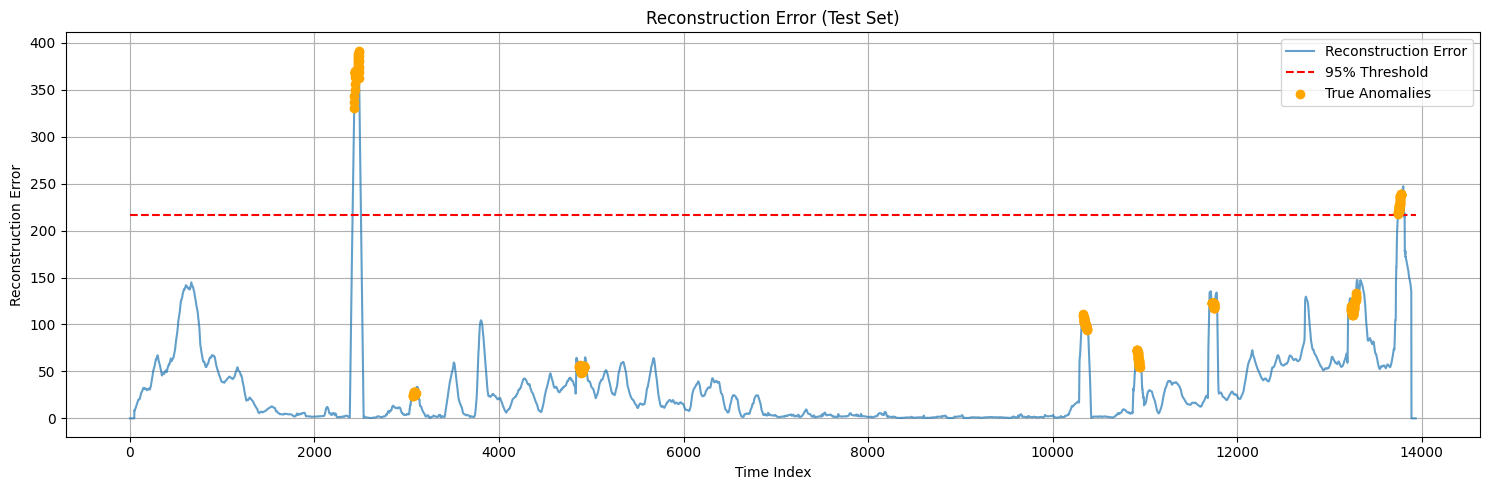

In [16]:
# ------------------ 9️⃣ Threshold Optimization & Metrics ------------------

# --- Threshold Optimization ---
# Try thresholds between 0 and max error
thresholds = np.linspace(valid_err.min(), valid_err.max(), 200)
f1_scores = []

for thr in thresholds:
    preds = (valid_err >= thr).astype(int)
    f1 = f1_score(valid_labels, preds)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold: {best_threshold:.6f} with F1-score: {best_f1:.4f}")

preds = (valid_err >= best_threshold).astype(int)

roc_auc = roc_auc_score(valid_labels, valid_err)
precision = precision_score(valid_labels, preds)
recall    = recall_score(valid_labels, preds)
f1        = f1_score(valid_labels, preds)
ap_score  = average_precision_score(valid_labels, valid_err)

print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AP: {ap_score:.4f}")

# ------------------ 🔟 Plot ------------------
plt.figure(figsize=(15,5))
plt.plot(pointwise_err, label='Reconstruction Error', alpha=0.7)
plt.hlines(best_threshold, 0, len(pointwise_err), colors='r', linestyles='dashed', label='95% Threshold')
plt.scatter(np.where(anomaly_labels==1), pointwise_err[anomaly_labels==1], color='orange', label='True Anomalies', zorder=5)
plt.title('Reconstruction Error (Test Set)')
plt.xlabel('Time Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Confusion Matrix as string:
[[13498    74]
 [  230    86]]


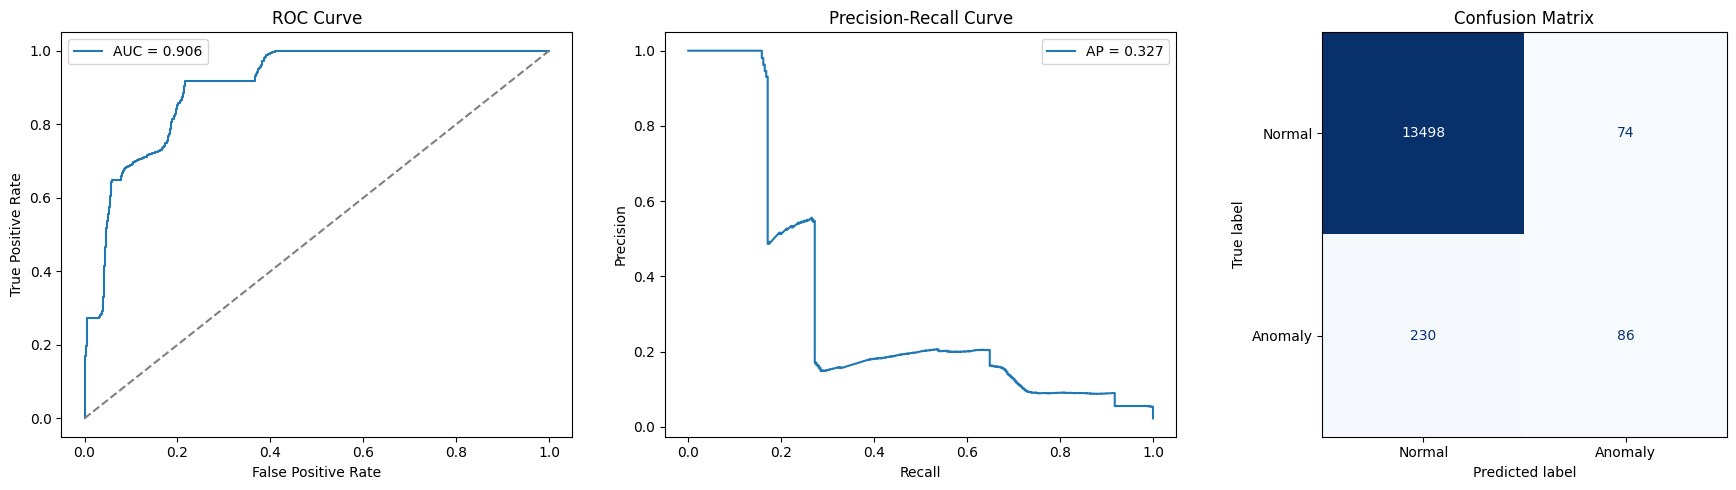

In [17]:
# --------- Plot ROC, Precision-Recall Curves and Confusion Matrix  ---------

from sklearn.metrics import roc_curve, precision_recall_curve,confusion_matrix, ConfusionMatrixDisplay

# Plot ROC and PR curves
fpr, tpr, _ = roc_curve(valid_labels, valid_err)
prec_curve, rec_curve, _ = precision_recall_curve(valid_labels, valid_err)

# Compute confusion matrix
cm = confusion_matrix(valid_labels, preds)

print("Confusion Matrix as string:")
print(str(cm))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])

plt.figure(figsize=(18, 5))

# ROC Curve
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 3, 2)
plt.plot(rec_curve, prec_curve, label=f"AP = {ap_score:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

# Confusion Matrix
plt.subplot(1,3,3)
disp.plot(ax=plt.gca(), cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()

In [18]:
# print accuracy
accuracy = np.sum(preds == valid_labels) / len(valid_labels)
print(f"Accuracy: {accuracy:.4f}")

print(f"Predicted anomalies (TP+FP) = {np.sum(preds)}")
print(f"True anomalies = {np.sum(valid_labels)}")
print(f"Precision(actual anomalies percentage): {precision:.4f} (True anomalies / Predicted anomalies)")

print(f"Missed anomalies (FN): {np.sum((valid_labels == 1) & (preds == 0))}")
print(f"False alarms (FP): {np.sum((valid_labels == 0) & (preds == 1))}")


Accuracy: 0.9781
Predicted anomalies (TP+FP) = 160
True anomalies = 316.0
Precision(actual anomalies percentage): 0.5375 (True anomalies / Predicted anomalies)
Missed anomalies (FN): 230
False alarms (FP): 74


In [19]:
# Your model is good at identifying normal points (very few FPs, high TN rate).

# But it misses many anomalies (high FN count), meaning low recall.

# You are conservative in predicting anomalies — you catch fewer but with moderate precision.

# If the goal is to catch as many anomalies as possible, you might need to:

# Lower the threshold (to improve recall, but risk more false alarms).

# Use a more anomaly-sensitive loss function or model.

# Combine reconstruction error with other anomaly features.

In [20]:
# Quick roadmap (what I’d try first)
# Swap loss → SmoothL1Loss, retrain.

# Use combined score (MSE+MAE+MaxErr), re-run evaluation.

# Threshold via “max recall with precision ≥ X”; test X ∈ {0.4, 0.5, 0.6}.

# If false alarms still too high for desired recall, switch to FPR-capped thresholding and tune max_fpr.